In [1]:
import math
import numpy as np
import copy
import matplotlib.pyplot as plt

# To load the data
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# To define the model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Load the data

In [3]:
TRAIN_SIZE = 1500
VALID_SIZE = 250
TEST_SIZE = 250

BATCH_SIZE = 125

EPOCHS_MAX = 10

NUM_FEATURES = 28*28
NUM_CLASSES = 10

RANDOM_SEED = 1

In [4]:
dataset_train = MNIST('data', train=True, download=True, transform=ToTensor())
dataset_test = MNIST('data', train=False, download=True, transform=ToTensor())

In [5]:
dataset_training = torch.utils.data.Subset(dataset_train, range(0, TRAIN_SIZE))
#dataset_validating = torch.utils.data.Subset(dataset_test, range(0, VALID_SIZE))
dataset_testing = torch.utils.data.Subset(dataset_test, range(VALID_SIZE, VALID_SIZE + TEST_SIZE))

dataloader_train = DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
#dataloader_valid = DataLoader(dataset_validating, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_testing, batch_size=BATCH_SIZE, shuffle=False)

# Define the model

In [6]:
# RESNET-18

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        
        self.inplanes = 64
        in_dim = 1
        
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        
        downsample = None
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
    return model

In [7]:
def compute_accuracy(model, data_loader):
    
    correct_pred = 0
    num_examples = 0
    
    for i, (features, targets) in enumerate(data_loader):

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

In [8]:
torch.manual_seed(RANDOM_SEED)
model = resnet18(NUM_CLASSES)

### Define the loss function

In [9]:
criterion = nn.CrossEntropyLoss()

### Define the optimizer

In [10]:
class signSGD(optim.Optimizer):

    def __init__(self, params, lr=0.0001):

        defaults = dict(lr=lr)
        super(signSGD, self).__init__(params, defaults)

    def step(self):

        for group in self.param_groups:

            for p in group['params']:

                if p.grad is None:
                    continue

                p.data -= group['lr'] * torch.sign(p.grad)

In [11]:
class signumSGD(optim.Optimizer):

    def __init__(self, params, lr=0.0001, beta=0.9):
        
        defaults = dict(lr=lr)
        self.beta = beta
        self.momentum = None
        
        super(signumSGD, self).__init__(params, defaults)

    def step(self):

        if self.momentum == None:
            self.momentum = [None for group in self.param_groups]

        for i, group in enumerate(self.param_groups):
            
            if self.momentum[i] == None:
                self.momentum[i] = [torch.zeros(p.size()) for p in group["params"]]
            
            for j, p in enumerate(group['params']):
                
                if p.grad is None:
                    continue

                self.momentum[i][j] = self.beta * self.momentum[i][j] + (1 - self.beta) * p.grad
                
                p.data -= group['lr'] * torch.sign(self.momentum[i][j])

# Train the models

In [12]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_test, epochs):
    
    losses = []
    accs = []
    
    for ep in range(epochs):
        
        model.train()
        
        for it, batch in enumerate(dataloader_train):
            
            x, y = batch
            
            logits, probas = model.forward(x)
            
            loss = criterion(logits, y)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        
        with torch.no_grad():
            
            acc = compute_accuracy(model, dataloader_test)
            
        print("Epoch {}/{} | Loss = {:.2f} & Acc = {:.1f}".format(ep+1, epochs, float(loss), acc))

        losses.append(float(loss))
        accs.append(acc)
        
    print("")
            
    return losses, accs

### SGD

In [13]:
# Hyper-parameters
lr = 0.1

# Re-initialize the model and the optimizer parameters
model_sgd = resnet18(NUM_CLASSES)
optimizer_SGD = torch.optim.SGD(model_sgd.parameters(), lr)

# Train the model on test set on the train and evaluate it on test set
losses_SGD, accs_SGD = train_model(model_sgd, criterion, optimizer_SGD, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.58 & Acc = 13.2
Epoch 2/10 | Loss = 0.24 & Acc = 66.4
Epoch 3/10 | Loss = 0.04 & Acc = 90.4
Epoch 4/10 | Loss = 0.01 & Acc = 94.4
Epoch 5/10 | Loss = 0.01 & Acc = 94.8
Epoch 6/10 | Loss = 0.00 & Acc = 94.8
Epoch 7/10 | Loss = 0.00 & Acc = 95.2
Epoch 8/10 | Loss = 0.00 & Acc = 94.8
Epoch 9/10 | Loss = 0.00 & Acc = 95.6
Epoch 10/10 | Loss = 0.00 & Acc = 95.2



### SGD with momentum

In [14]:
# Hyper-parameters
lr = 0.01
momentum=0.85

# Re-initialize the model and the optimizer parameters
model_SGD_momentum = resnet18(NUM_CLASSES)
optimizer_SGD_momentum = torch.optim.SGD(model_SGD_momentum.parameters(), lr, momentum)

# Train the model on test set on the train and evaluate it on test set
losses_SGD_momentum, accs_SGD_momentum = train_model(model_SGD_momentum, criterion, optimizer_SGD_momentum, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.41 & Acc = 13.6
Epoch 2/10 | Loss = 0.15 & Acc = 62.0
Epoch 3/10 | Loss = 0.08 & Acc = 85.6
Epoch 4/10 | Loss = 0.01 & Acc = 90.0
Epoch 5/10 | Loss = 0.01 & Acc = 91.6
Epoch 6/10 | Loss = 0.00 & Acc = 91.2
Epoch 7/10 | Loss = 0.00 & Acc = 91.2
Epoch 8/10 | Loss = 0.00 & Acc = 91.6
Epoch 9/10 | Loss = 0.00 & Acc = 91.6
Epoch 10/10 | Loss = 0.00 & Acc = 91.6



### Sign SGD

In [15]:
# Hyper-parameters
lr = 0.0001

# Re-initialize the model and the optimizer parameters
model_sign = resnet18(NUM_CLASSES)
optimizer_sign = signSGD(model_sign.parameters(), lr)

# Train the model on the train and validation sets
losses_sign, accs_sign = train_model(model_sign, criterion, optimizer_sign, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.86 & Acc = 13.2
Epoch 2/10 | Loss = 0.31 & Acc = 13.2
Epoch 3/10 | Loss = 0.06 & Acc = 13.2
Epoch 4/10 | Loss = 0.01 & Acc = 16.8
Epoch 5/10 | Loss = 0.01 & Acc = 65.2
Epoch 6/10 | Loss = 0.00 & Acc = 88.4
Epoch 7/10 | Loss = 0.00 & Acc = 89.6
Epoch 8/10 | Loss = 0.00 & Acc = 90.0
Epoch 9/10 | Loss = 0.00 & Acc = 90.8
Epoch 10/10 | Loss = 0.00 & Acc = 90.4



### Signum SGD

In [16]:
# Hyper-parameters
lr = 0.0001
beta = 0.9

# Re-initialize the model and the optimizer parameters
model_signum = resnet18(NUM_CLASSES)
optimizer_signum = signumSGD(model_signum.parameters(), lr, beta)

# Train the model on the train and validation sets
losses_signum, accs_signum = train_model(model_signum, criterion, optimizer_signum, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.57 & Acc = 13.2
Epoch 2/10 | Loss = 0.13 & Acc = 20.8
Epoch 3/10 | Loss = 0.03 & Acc = 26.4
Epoch 4/10 | Loss = 0.03 & Acc = 59.2
Epoch 5/10 | Loss = 0.03 & Acc = 86.8
Epoch 6/10 | Loss = 0.02 & Acc = 88.4
Epoch 7/10 | Loss = 0.03 & Acc = 90.0
Epoch 8/10 | Loss = 0.18 & Acc = 88.0
Epoch 9/10 | Loss = 0.09 & Acc = 91.2
Epoch 10/10 | Loss = 0.03 & Acc = 90.0



### Adagrad

In [17]:
# Hyper-parameters
lr = 0.01
lr_decay = 0
weight_decay = 0.001
initial_accumulator_value = 0
eps = 1e-10

# Re-initialize the model and the optimizer parameters
model_adagrad = resnet18(NUM_CLASSES)
optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr, lr_decay, weight_decay, initial_accumulator_value, eps)

# Train the model on the train and validation sets
losses_adagrad, accs_adagrad = train_model(model_adagrad, criterion, optimizer_adagrad, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.78 & Acc = 8.0
Epoch 2/10 | Loss = 0.21 & Acc = 28.0
Epoch 3/10 | Loss = 0.08 & Acc = 52.8
Epoch 4/10 | Loss = 0.13 & Acc = 79.2
Epoch 5/10 | Loss = 0.03 & Acc = 94.8
Epoch 6/10 | Loss = 0.02 & Acc = 93.2
Epoch 7/10 | Loss = 0.01 & Acc = 95.6
Epoch 8/10 | Loss = 0.00 & Acc = 95.2
Epoch 9/10 | Loss = 0.01 & Acc = 96.4
Epoch 10/10 | Loss = 0.00 & Acc = 96.4



### Adam

In [18]:
# Hyper-parameters
lr = 0.001
beta1 = 0.92
beta2 = 0.999
eps = 1e-8
weight_decay = 0.001

# Re-initialize the model and the optimizer parameters
model_adam = resnet18(NUM_CLASSES)
optimizer_adam = optim.Adam(model_adam.parameters(), lr, betas = (beta1, beta2), eps=eps, weight_decay=weight_decay)

# Train the model on the train and validation sets
losses_adam, accs_adam = train_model(model_adam, criterion, optimizer_adam, dataloader_train, dataloader_test, EPOCHS_MAX)

Epoch 1/10 | Loss = 0.32 & Acc = 13.2
Epoch 2/10 | Loss = 0.15 & Acc = 13.2
Epoch 3/10 | Loss = 0.06 & Acc = 13.6
Epoch 4/10 | Loss = 0.07 & Acc = 58.8
Epoch 5/10 | Loss = 0.02 & Acc = 80.0
Epoch 6/10 | Loss = 0.05 & Acc = 89.2
Epoch 7/10 | Loss = 0.02 & Acc = 89.2
Epoch 8/10 | Loss = 0.01 & Acc = 82.4
Epoch 9/10 | Loss = 0.02 & Acc = 90.0
Epoch 10/10 | Loss = 0.01 & Acc = 92.4



### Ploting

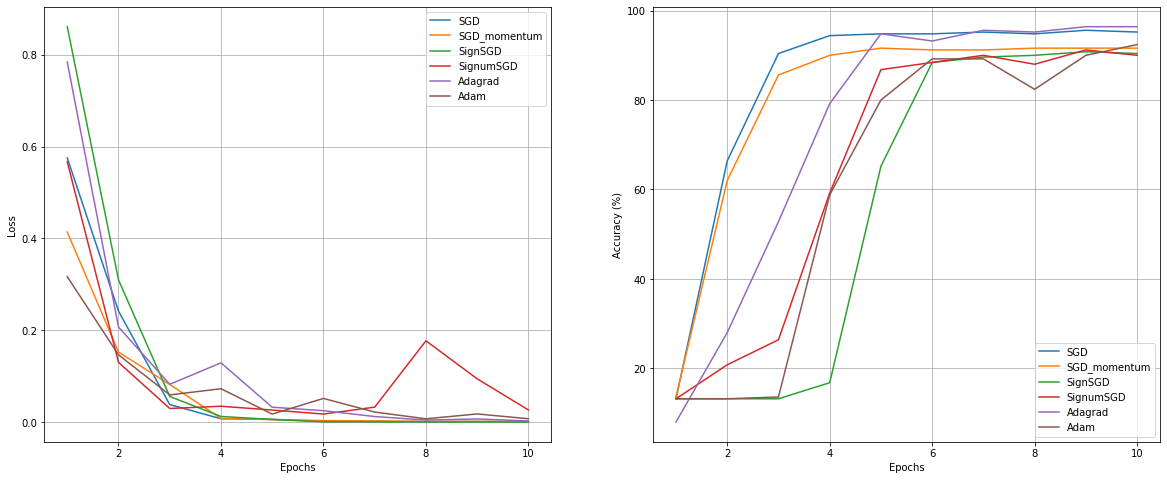

In [19]:
x = range(1, EPOCHS_MAX+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].plot(x, losses_SGD, label = "SGD")
axes[0].plot(x, losses_SGD_momentum, label = "SGD_momentum")
axes[0].plot(x, losses_sign, label = "SignSGD")
axes[0].plot(x, losses_signum, label = "SignumSGD")
axes[0].plot(x, losses_adagrad, label = "Adagrad")
axes[0].plot(x, losses_adam, label = "Adam")

axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epochs")

axes[0].legend()
axes[0].grid()

axes[1].plot(x, accs_SGD, label = "SGD")
axes[1].plot(x, accs_SGD_momentum, label = "SGD_momentum")
axes[1].plot(x, accs_sign, label = "SignSGD")
axes[1].plot(x, accs_signum, label = "SignumSGD")
axes[1].plot(x, accs_adagrad, label = "Adagrad")
axes[1].plot(x, accs_adam, label = "Adam")

axes[1].set_ylabel("Accuracy (%)")
axes[1].set_xlabel("Epochs")

axes[1].legend()
axes[1].grid()

### Workers

In [20]:
class FC(nn.Module):

    def __init__(self):

        super(FC, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):

        # The images are first flatten to vectors
        x = x.flatten(-3)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x,dim=1)

In [21]:
def accuracy(x, y):

    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    
    return np.mean(np.argmax(x, axis=1) == y)

In [22]:
class signumSGD_worker(optim.Optimizer):

    def __init__(self, params, lr=0.01, beta=0.1):

        self.beta = beta
        self.momentum = None

        defaults = dict(lr=lr)
        super(signumSGD_worker, self).__init__(params, defaults)

    def step(self):

        if self.momentum == None:
            self.momentum = [None for group in self.param_groups]
            
        signs = [[torch.zeros(p.size()) for p in group['params']] for group in self.param_groups]

        for i, group in enumerate(self.param_groups):
            
            if self.momentum[i] == None:
                self.momentum[i] = [torch.zeros(p.size()) for p in group["params"]]
                
            for j, p in enumerate(group['params']):
                
                if p.grad is None:
                    continue

                self.momentum[i][j] = self.beta * self.momentum[i][j] + (1 - self.beta) * p.grad
                signs[i][j] = torch.sign(self.momentum[i][j])
                
        return signs
            
    def update(self, signs):
            
        for i, group in enumerate(self.param_groups):
            for j, p in enumerate(group['params']):
                p.data -= group['lr'] * torch.sign(signs[i][j])

In [23]:
class worker_signum:
    
    def __init__(self, learning_rate, beta, batch):
        
        self.model = FC()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = signumSGD_worker(self.model.parameters(), lr=learning_rate, beta=beta)
        self.batch = batch
        
    def train(self):
        
        x,y = self.batch
        
        self.model.train()
        
        logits = self.model.forward(x)
            
        loss = self.criterion(logits, y)
        loss.backward()

        signs = self.optimizer.step()
        self.optimizer.zero_grad()
        
        return signs, float(loss)
    
    def update(self, signs):
        self.optimizer.update(signs)

In [24]:
def evaluating_workers(learning_rate, beta, dataloader_train, dataloader_test, epochs=EPOCHS_MAX):
    
    # This is the server
    
    workers = []
    
    for it, batch in enumerate(dataloader_train):
         workers.append(worker_signum(learning_rate, beta, batch))
            
    M = len(workers)
    
    print("--> " + str(M) + " travailleurs")
            
    final_model = FC()
    criterion = nn.CrossEntropyLoss()
    optimizer = signumSGD_worker(final_model.parameters(), lr=learning_rate, beta=beta)
    
    losses = []
    accs = []
            
    for ep in range(epochs*M):
        
        # Training
        
        full_signs = None
        full_loss = 0
        
        for worker in workers:
            
            signs, loss = worker.train()
            
            if full_signs == None:
                full_signs = signs
            else:
                for i in range(len(full_signs)):
                    for j in range(len(full_signs[i])):
                        full_signs[i][j] = torch.add(full_signs[i][j], signs[i][j])
                        
            full_loss += loss
                
        # Update
        
        for worker in workers:
            worker.update(full_signs)
        
        optimizer.update(full_signs)
        
        # Eval

        if (ep+1)%M == 0:
        
            final_model.eval()
            
            with torch.no_grad():
                
                acc_run = 0
                
                for it, batch in enumerate(dataloader_test):
                    x, y = batch
                    curr_bs = x.shape[0]
                    acc_run += accuracy(final_model(x), y) * curr_bs
                    
                acc = acc_run / len(dataloader_test.dataset) * 100
                
            print("Epoch {}/{} | Loss = {:.2f} & Acc = {:.1f}".format(ep+1, epochs*M, full_loss, acc))
            
            losses.append(full_loss)
            accs.append(acc)
        
    print("")
    
    return losses, accs, final_model

In [29]:
# Hyper-parameters
lr = 0.01
beta = 0.9

losses_workers, accs_workers, model_workers = evaluating_workers(lr, beta, dataloader_train, dataloader_test, EPOCHS_MAX)

--> 12 travailleurs
Epoch 12/120 | Loss = 19.87 & Acc = 30.0
Epoch 24/120 | Loss = 3.49 & Acc = 79.6
Epoch 36/120 | Loss = 1.32 & Acc = 84.0
Epoch 48/120 | Loss = 0.69 & Acc = 85.6
Epoch 60/120 | Loss = 0.97 & Acc = 84.0
Epoch 72/120 | Loss = 0.74 & Acc = 83.6
Epoch 84/120 | Loss = 2.15 & Acc = 84.0
Epoch 96/120 | Loss = 2.39 & Acc = 84.4
Epoch 108/120 | Loss = 2.28 & Acc = 83.6
Epoch 120/120 | Loss = 1.84 & Acc = 84.0



## Ploting + Workers

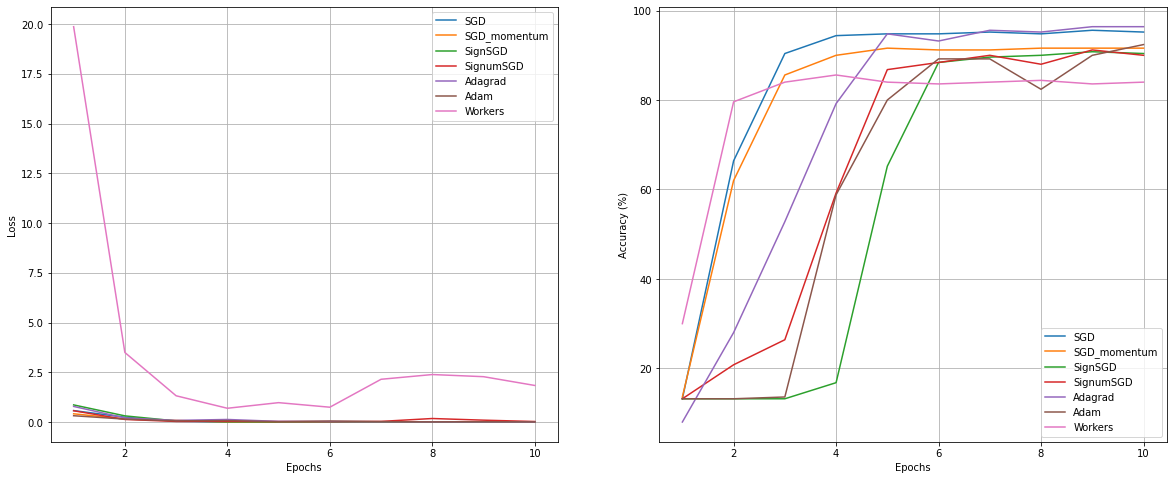

In [30]:
x = range(1, EPOCHS_MAX+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].plot(x, losses_SGD, label = "SGD")
axes[0].plot(x, losses_SGD_momentum, label = "SGD_momentum")
axes[0].plot(x, losses_sign, label = "SignSGD")
axes[0].plot(x, losses_signum, label = "SignumSGD")
axes[0].plot(x, losses_adagrad, label = "Adagrad")
axes[0].plot(x, losses_adam, label = "Adam")
axes[0].plot(x, losses_workers, label = "Workers")

axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epochs")

axes[0].legend()
axes[0].grid()

axes[1].plot(x, accs_SGD, label = "SGD")
axes[1].plot(x, accs_SGD_momentum, label = "SGD_momentum")
axes[1].plot(x, accs_sign, label = "SignSGD")
axes[1].plot(x, accs_signum, label = "SignumSGD")
axes[1].plot(x, accs_adagrad, label = "Adagrad")
axes[1].plot(x, accs_adam, label = "Adam")
axes[1].plot(x, accs_workers, label = "Workers")

axes[1].set_ylabel("Accuracy (%)")
axes[1].set_xlabel("Epochs")

axes[1].legend()
axes[1].grid()